# 模型常量

In [ ]:
# %load model_constant.py
#cnn_rul_debug_savemodel.py
#TODO
model_file_name = 'model_2017MMDD_AC.pkl'

#cnn_rul_debug_deconResult_sep.py
model_rev_sep_file_name = 'model_rev_sep'+model_file_name[5:]

#cnn_rul_debug_deconResult_mul.py
model_rev_mul_file_name = 'model_rev_mul'+model_file_name[5:]

#deconvFunctions.py
model_rev_file_name = model_rev_mul_file_name


# 模型训练

In [ ]:
# %load cnn_rul_debug_savemodel.py
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
import model_constant as mc

#import pdb
#---------------
#滑动窗口
def windows(nrows, size): #（数据行数，窗口打下）
    start,step = 0, 2     # 窗口开始位置，窗口滑动步长
    while start < nrows:
        yield start, start + size #返回窗口的起始位置
        start += step

#数据分段
def segment_signal(features,labels,window_size = 15): #（特征数据，数据对应标签，窗口大小默认15）
    segments = np.empty((0,window_size)) #返回未初始化的shape形状数据，此处相当于声明了个15列的变量
    segment_labels = np.empty((0)) #此处相当于申请了变量
    nrows = len(features) 
    for (start, end) in windows(nrows,window_size): #从生成器返回所有的窗口
        if(len(data.iloc[start:end]) == window_size):
            segment = features[start:end].T  #转置，得到24 x 15，相当于一个属性一行 
            label = labels[(end-1)]
            segments = np.vstack([segments,segment]) #垂直堆叠
            segment_labels = np.append(segment_labels,label) #一行数据
    segments = segments.reshape(-1,24,window_size,1) #batch_size不用管所以设为-1，channel也设为1 
    segment_labels = segment_labels.reshape(-1,1) #获得一列，行数根据实际展开
    return segments,segment_labels

#---------------	
#读取数据
data = pd.read_csv("PHM08.csv")#, nrows=50)
features = scale(data.iloc[:,2:26]) # select required columns and scale them
labels = data.iloc[:,26] # select RU

#---------------
#获得分段数据
segments, labels = segment_signal(features,labels)

#---------------
#拆分训练+测试数据
train_test_split = np.random.rand(len(segments)) < 0.7 #rand根据shape生成0~1的随机数，train_test_split有70%为true，30%false
train_x = segments[train_test_split] #相当于随机了70%作为输入
train_y = labels[train_test_split]
test_x = segments[~train_test_split]
test_y = labels[~train_test_split]

#---------------
#得到权重变量
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1) #截断的随机分布输出，保证生成值在均值附近
    return tf.Variable(initial)

#得到偏置变量
def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

#卷积
#num_channels：可理解为当前层的feature map的个数（filter个数）
#depth：是将要得到的feature map个数（filter个数）
def apply_conv(x,kernel_height,kernel_width,num_channels,depth):
    weights = weight_variable([kernel_height, kernel_width, num_channels, depth])
    biases = bias_variable([depth])
    return weights, biases, tf.nn.relu(tf.add(tf.nn.conv2d(x, weights,[1,1,1,1],padding="VALID"),biases)) #relu:计算激活函数，即max(features, 0)

#max pool
#stride_size：步幅大小，应用max后向后滑动的元素个数    
def apply_max_pool(x,kernel_height,kernel_width,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_height, kernel_width, 1], strides=[1, 1, stride_size, 1], padding = "VALID")

#---------------	
#基本常量
num_labels = 1
batch_size = 2
num_hidden = 800
learning_rate = 0.0001
training_epochs = 30
input_height = 24
input_width = 15
num_channels = 1
total_batches = train_x.shape[0] #有多少个24*15的segment

#---------------
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

#定义两个卷积和pool层
w1, b1, c1 = apply_conv(X, kernel_height = 24, kernel_width = 4, num_channels = 1, depth = 8) 
p1 = apply_max_pool(c1,kernel_height = 1, kernel_width = 2, stride_size = 2) 
w2, b2, c2 = apply_conv(p1, kernel_height = 1, kernel_width = 3, num_channels = 8, depth = 14) 
p2 = apply_max_pool(c2,kernel_height = 1, kernel_width = 2, stride_size = 2) 

shape = p2.get_shape().as_list()
flat = tf.reshape(p2, [-1, shape[1] * shape[2] * shape[3]])#横向展开

#前向传播

#输入计算
f_weights = weight_variable([shape[1] * shape[2] * shape[3], num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(flat, f_weights),f_biases))

#输出计算
out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.add(tf.matmul(f, out_weights),out_biases)

#---------------
#后向传播
cost_function = tf.reduce_mean(tf.square(y_- Y))#损失函数
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)#梯度下降

import time
f = open("output_cnn_rul_debug.txt", "a+")
f.write(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+"\n")
f.write("-------------------\n")
#---------------
#计算图
#training_epochs = 1
#total_batches = 5
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Training set MSE")
    for epoch in range(training_epochs): #每一个epoch后，会执行权重更新
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size),:]
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, Y : batch_y})
         
            '''
            if offset==0:
                print session.run(out_weights)[0:10,:]
            '''
        #pdb.set_trace() 

        p_tr = session.run(y_, feed_dict={X:  train_x})
        tr_mse = tf.reduce_mean(tf.square(p_tr - train_y))
        f.write("\nepoch:%d mse:%.4f"%(epoch,session.run(tr_mse)))
        
        #pdb.set_trace() 
        
        tmp = np.where(train_y==0, 0, abs(p_tr-train_y)/train_y)
        accuracy = (1-tf.reduce_mean(tmp[0]))*100
        f.write("   accuracy: %.2f"%session.run(accuracy))

        print(session.run(accuracy))
        print(session.run(tr_mse))

    #pdb.set_trace()

    #save model
    model = {}
    model['train_x'] = train_x
    model['train_y'] = train_y
    model['test_x'] = test_x
    model['test_y'] = test_y
    model['l1_input_shape'] = [1,24,15,1]
    model['l1_kernal_shape'] = [1,24,4,1]
    model['l1_kernal_stride'] = [1,1,1,1]
    model['l1_w'] = session.run(w1)
    model['l1_b'] = session.run(b1)
    model['l1_kout_shape'] = [1,1,12,8]
    model['l1_pool_shape'] = [1,1,2,1]
    model['l1_pool_stride'] = [1,1,2,1]
    model['l1_pout_shape'] = [1,1,6,8]

    model['l2_input_shape'] = [1,1,6,8]
    model['l2_kernal_shape'] = [1,3,8,14]
    model['l2_kernal_stride'] = [1,1,1,1]
    model['l2_w'] = session.run(w2)
    model['l2_b'] = session.run(b2)
    model['l2_kout_shape'] = [1,1,4,14]
    model['l2_pool_shape'] = [1,1,2,1]
    model['l2_pool_stride'] = [1,1,2,1]
    model['l2_pout_shape'] = [1,1,2,14]

    model['f_input_w'] = session.run(f_weights)
    model['f_input_b'] = session.run(f_biases)
    
    model['f_output_w'] = session.run(out_weights)
    model['f_output_b'] = session.run(out_biases)

    import helpFunctions as hf
    hf.savedic(mc.model_file_name, model)

    #test case
    p_ts = session.run(y_, feed_dict={X:  test_x})
    ts_mse = tf.reduce_mean(tf.square(p_ts - test_y))
    f.write("\nTest set MSE: %.4f" % session.run(ts_mse))
    print("\nTest set MSE: %.4f" %session.run(ts_mse))

    tmp = np.where(test_y==0, 0, abs(p_ts-test_y)/test_y)
    accuracy = (1-tf.reduce_mean(tmp[0]))*100
    #p_acc = session.run(accuracy, feed_dict={X:test_x, Y:test_y})
    f.write("\nTest Accuracy: %.2f"%session.run(accuracy))
    print("\nTest Accuracy: %.2f"%session.run(accuracy))

f.write("\n\n")
f.close()






# 输入重构

## 单特征重构

In [ ]:
# %load cnn_rul_debug_deconResult_sep.py
#import pandas as pd
import numpy as np
import tensorflow as tf
#from sklearn.preprocessing import scale
#import pdb
import model_constant as mc
'''
--------------------------
将每一层的特征分别重构输入
--------------------------
'''
#---------------	
#load the model
import helpFunctions as hf
model = hf.readdic(mc.model_rev_sep_file_name)
train_x = model['train_x'] 
train_y = model['train_y']
test_x = model['test_x']
test_y = model['test_y']

#得到权重变量
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1) #截断的随机分布输出，保证生成值在均值附近
    return tf.Variable(initial)

#得到偏置变量
def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

#卷积
#num_channels：可理解为当前层的feature map的个数（filter个数）
#depth：是将要得到的feature map个数（filter个数）
def apply_conv(x,kernel_height,kernel_width,num_channels,depth):
    weights = weight_variable([kernel_height, kernel_width, num_channels, depth])
    biases = bias_variable([depth])
    return weights, biases, tf.nn.relu(tf.add(tf.nn.conv2d(x, weights,[1,1,1,1],padding="VALID"),biases)) #relu:计算激活函数，即max(features, 0)

#max pool
#stride_size：步幅大小，应用max后向后滑动的元素个数    
def apply_max_pool(x,kernel_height,kernel_width,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_height, kernel_width, 1], strides=[1, 1, stride_size, 1], padding = "VALID")

#---------------	
#基本常量
num_labels = 1
batch_size = 2
num_hidden = 800
learning_rate = 0.0001
training_epochs = 30
input_height = 24
input_width = 15
num_channels = 1
total_batches = train_x.shape[0] #有多少个24*15的segment

#---------------
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

#定义两个卷积和pool层
w1, b1, c1 = apply_conv(X, kernel_height = 24, kernel_width = 4, num_channels = 1, depth = 8) 
p1 = apply_max_pool(c1,kernel_height = 1, kernel_width = 2, stride_size = 2) 
w2, b2, c2 = apply_conv(p1, kernel_height = 1, kernel_width = 3, num_channels = 8, depth = 14) 
p2 = apply_max_pool(c2,kernel_height = 1, kernel_width = 2, stride_size = 2) 

shape = p2.get_shape().as_list()
flat = tf.reshape(p2, [-1, shape[1] * shape[2] * shape[3]])#横向展开

#前向传播

#输入计算
f_weights = weight_variable([shape[1] * shape[2] * shape[3], num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(flat, f_weights),f_biases))

#输出计算
out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.add(tf.matmul(f, out_weights),out_biases)

#---------------
#后向传播
cost_function = tf.reduce_mean(tf.square(y_- Y))#损失函数
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)#梯度下降

#---------------
#计算图
with tf.Session() as session:
    tf.global_variables_initializer().run()
    tf.assign_add(w1,model['l1_w'])
    tf.assign_add(b1,model['l1_b'])
    tf.assign_add(w2,model['l2_w'])
    tf.assign_add(b2,model['l2_b'])
    tf.assign_add(f_weights,model['f_input_w'])
    tf.assign_add(f_biases,model['f_input_b'])
    tf.assign_add(out_weights,model['f_output_w'])
    tf.assign_add(out_biases,model['f_output_b'])

    import deconvFunctions as deconv
    model_rev = {}
    l1 = np.array(list())
    l2 = np.array(list())
    num = 10 #range(test_x.shape[0])
    for i in range(10):
        im = test_x[i:(i+1)]
       
        #feed a test ‘image’
        p1_v = session.run(p1, feed_dict={X:im})#deconv.get_activations(w1)
        c1_v = session.run(c1, feed_dict={X:im})
        w1_v = session.run(w1, feed_dict={X:im})
        
        p2_v = session.run(p2, feed_dict={X:im})
        c2_v = session.run(c2, feed_dict={X:im})
        w2_v = session.run(w2, feed_dict={X:im})

        #pdb.set_trace()

        #分别重构回去
        #第一层特征重构
        l1_recons = np.array(list())
        for j in range(c1_v.shape[-1]):
            c1_v_t = c1_v[...,j]
            c1_v_t = c1_v_t[...,np.newaxis]
            unrelu1 = tf.nn.relu(c1_v_t)
            w1_v_t = w1_v[...,j]
            w1_v_t = w1_v_t[...,np.newaxis]
            deconv1 = tf.nn.conv2d_transpose(unrelu1, w1_v_t, output_shape=model['l1_input_shape'], strides=model['l1_kernal_stride'], padding='VALID')
            
            res = session.run(deconv1)
            if j==0:
                l1_recons = res
            else:
                l1_recons = np.append(l1_recons, res, axis=3)
        
        #pdb.set_trace()
        
        #第二层特征重构
        l2_recons = np.array(list())
        for j in range(c2_v.shape[-1]):
            c2_v_t = c2_v[...,j]
            c2_v_t = c2_v_t[...,np.newaxis]
            unrelu2 = tf.nn.relu(c2_v_t)
            w2_v_t = w2_v[...,j]
            w2_v_t = w2_v_t[...,np.newaxis]
            deconv2 = tf.nn.conv2d_transpose(unrelu2, w2_v_t, output_shape=model['l2_input_shape'], strides=model['l2_kernal_stride'], padding='VALID')
            res = session.run(deconv2)
            unpool1 = deconv.apply_unpool(c1_v, res, 2, 2)
            unrelu1 = tf.nn.relu(unpool1)
            deconv1 = tf.nn.conv2d_transpose(unrelu1, w1_v, output_shape=model['l1_input_shape'], strides=model['l1_kernal_stride'], padding='VALID')
            res = session.run(deconv1)
            if j==0 :
                l2_recons = res
            else:
                l2_recons = np.append(l2_recons, res, axis=3)
    
        if i==0 :
            l1 = l1_recons
            l2 = l2_recons
        else:
            l1 = np.append(l1, l1_recons, axis=0)
            l2 = np.append(l2, l2_recons, axis=0)
        
        #pdb.set_trace()
    
    model_rev['input'] = test_x[0:num]
    model_rev['l1'] = l1
    model_rev['l2'] = l2
    
    import helpFunctions as hf
    hf.savedic(mc.model_rev_sep_file_name,model_rev)

    #pdb.set_trace()



## 多特征重构

In [ ]:
# %load cnn_rul_debug_deconResult_mul.py
#import pandas as pd
import numpy as np
import tensorflow as tf
#from sklearn.preprocessing import scale
#import pdb
import model_constant as mc

'''
-------------------------------
将每一层的所有特征结合重构输入
-------------------------------
'''
#---------------	
#load the model
import helpFunctions as hf
model = hf.readdic(mc.model_file_name)
train_x = model['train_x'] 
train_y = model['train_y']
test_x = model['test_x']
test_y = model['test_y']

#得到权重变量
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1) #截断的随机分布输出，保证生成值在均值附近
    return tf.Variable(initial)

#得到偏置变量
def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

#卷积
#num_channels：可理解为当前层的feature map的个数（filter个数）
#depth：是将要得到的feature map个数（filter个数）
def apply_conv(x,kernel_height,kernel_width,num_channels,depth):
    weights = weight_variable([kernel_height, kernel_width, num_channels, depth])
    biases = bias_variable([depth])
    return weights, biases, tf.nn.relu(tf.add(tf.nn.conv2d(x, weights,[1,1,1,1],padding="VALID"),biases)) #relu:计算激活函数，即max(features, 0)

#max pool
#stride_size：步幅大小，应用max后向后滑动的元素个数    
def apply_max_pool(x,kernel_height,kernel_width,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_height, kernel_width, 1], strides=[1, 1, stride_size, 1], padding = "VALID")

#---------------	
#基本常量
num_labels = 1
batch_size = 2
num_hidden = 800
learning_rate = 0.0001
training_epochs = 30
input_height = 24
input_width = 15
num_channels = 1
total_batches = train_x.shape[0] #有多少个24*15的segment

#---------------
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

#定义两个卷积和pool层
w1, b1, c1 = apply_conv(X, kernel_height = 24, kernel_width = 4, num_channels = 1, depth = 8) 
p1 = apply_max_pool(c1,kernel_height = 1, kernel_width = 2, stride_size = 2) 
w2, b2, c2 = apply_conv(p1, kernel_height = 1, kernel_width = 3, num_channels = 8, depth = 14) 
p2 = apply_max_pool(c2,kernel_height = 1, kernel_width = 2, stride_size = 2) 

shape = p2.get_shape().as_list()
flat = tf.reshape(p2, [-1, shape[1] * shape[2] * shape[3]])#横向展开

#前向传播

#输入计算
f_weights = weight_variable([shape[1] * shape[2] * shape[3], num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(flat, f_weights),f_biases))

#输出计算
out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.add(tf.matmul(f, out_weights),out_biases)

#---------------
#后向传播
cost_function = tf.reduce_mean(tf.square(y_- Y))#损失函数
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)#梯度下降

#---------------
#计算图
with tf.Session() as session:
    tf.global_variables_initializer().run()
    tf.assign_add(w1,model['l1_w'])
    tf.assign_add(b1,model['l1_b'])
    tf.assign_add(w2,model['l2_w'])
    tf.assign_add(b2,model['l2_b'])
    tf.assign_add(f_weights,model['f_input_w'])
    tf.assign_add(f_biases,model['f_input_b'])
    tf.assign_add(out_weights,model['f_output_w'])
    tf.assign_add(out_biases,model['f_output_b'])

    import deconvFunctions as deconv
    model_rev = {}
    l1 = np.array(list())
    l2 = np.array(list())
    num = 10 # #TODO range(test_x.shape[0])
    for i in range(10):
        im = test_x[i:(i+1)]
       
        #feed a test ‘image’
        p1_v = session.run(p1, feed_dict={X:im})#deconv.get_activations(w1)
        c1_v = session.run(c1, feed_dict={X:im})
        w1_v = session.run(w1, feed_dict={X:im})
        
        p2_v = session.run(p2, feed_dict={X:im})
        c2_v = session.run(c2, feed_dict={X:im})
        w2_v = session.run(w2, feed_dict={X:im})

        #pdb.set_trace()

        #第一层特征重构
        unrelu1 = tf.nn.relu(c1_v)
        deconv1 = tf.nn.conv2d_transpose(unrelu1, w1_v, output_shape=model['l1_input_shape'], strides=model['l1_kernal_stride'], padding='VALID')
        l1_recons = session.run(deconv1)
    
        #pdb.set_trace()
        
        #第二层特征重构
        unrelu2 = tf.nn.relu(c2_v)
        deconv2 = tf.nn.conv2d_transpose(unrelu2, w2_v, output_shape=model['l2_input_shape'], strides=model['l2_kernal_stride'], padding='VALID')
        res = session.run(deconv2)
        unpool1 = deconv.apply_unpool(c1_v, res, 2, 2)
        unrelu1 = tf.nn.relu(unpool1)
        deconv1 = tf.nn.conv2d_transpose(unrelu1, w1_v, output_shape=model['l1_input_shape'], strides=model['l1_kernal_stride'], padding='VALID')
        l2_recons = session.run(deconv1)
        
        if i==0 :
            l1 = l1_recons
            l2 = l2_recons
        else:
            l1 = np.append(l1, l1_recons, axis=0)
            l2 = np.append(l2, l2_recons, axis=0)
        
        #pdb.set_trace()
    
    model_rev['input'] = test_x[0:num]
    model_rev['l1'] = l1
    model_rev['l2'] = l2
    
    import helpFunctions as hf
    hf.savedic(mc.model_rev_file_name,model_rev)

    #pdb.set_trace()



# 特征理解

In [4]:
# %load deconvResultCheck.py
import helpFunctions as hf
import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import model_constant as mc

model_dev = hf.readdic(mc.model_rev_file_name) 
#[batch_size, width, height, channels]
input_v = model_dev['input']
l1 = model_dev['l1']
l2 = model_dev['l2']

batch_size = input_v.shape[0]
varnum = input_v.shape[1]
timelen = input_v.shape[2]

'''
将制定输入的指定层的重建结果输出到同一张图
-----------------------------------------
im:一张输入图片
im_no:输入图片的编号
layer_recons: 某一层重建后的输入数据
layer_no：第几层的重建

得到一张图
'''
def saveLayerReconsInOne(im, im_no, layer_recons, layer_no):
    channel = layer_recons.shape[-1]
    plt.figure(figsize=(20,5*channel))
    plt.subplot((channel+1),1,1)
    plt.title("Original Data")
    plt.plot(im)
    for j in range(channel):
        l_t = layer_recons[im_no,...,j]
        #l2_t = l2[i,...,j]
        plt.subplot((channel+1),1,(j+2))
        plt.title("Layer1 Feature%d Reconstruction"%(j))
        plt.plot(l_t)
    plt.show()
    #file_name = get_file_name_path('test%d_all_l%d.png'%(im_no, layer_no), im_no);
    #plt.savefig(file_name)

'''
输出指定层的重构与原始值的差值曲线
输出一张图
'''
def saveLayerReconsInOneOfDiff(im, im_no, layer_recons, layer_no):
    channel = layer_recons.shape[-1]
    varnum = im.shape[0]
    plt.figure(figsize=(20,5*channel))
    plt.title("Test%d Layer%d Feature Reconstruction"%(im_no, layer_no))
    for i in range(channel):
        plt.subplot(channel,1,(i+1))
        plt.title('Feature%d Reconstruction'%(i))
        l_t = layer_recons[im_no,...,i]
        for j in range(varnum):
            plt.plot(l_t[j]-im[j], label='Var %d'%(j))
    plt.show()
    #file_name = get_file_name_path('test%d_all_diff_l%d.png'%(im_no, layer_no), im_no);
    #plt.savefig(file_name)

'''
输出所有输入，所有层重构后的差值图
'''
def checkAllReconsInOneOfDiff(input_start, input_end, input_data, layer_nums):
    for i in range(input_start, input_end+1):
        im = input_data[i,...,0]
        for j in range(1,layer_nums+1):
            saveLayerReconsInOneOfDiff(im, i, model_dev['l%d'%j], j)

'''
输出所有输入的所有层重构后的数据变化曲线
---------------------------------------
input_start: 输入数据集的开始index
input_end：输入数据集的结束index
input_data：输入数据集
layer_nums：有几层网络进行了重建操作
'''
def checkAllReconsInOne(input_start, input_end, input_data, layer_nums):
    #print input_end
    for i in range(input_start, input_end+1):
        im = input_data[i,...,0]
        for j in range(1,layer_nums+1):
            saveLayerReconsInOne(im, i, model_dev['l%d'%j], j)

'''
获得需要保存的文件的路径
------------------------
file_name：文件名称
'''
def get_file_name_path(file_name, im_no):
    cur_dir = os.getcwd()#获得当前路径
    
    folder_name = 'deconvResultCheck_figs/'+mc.model_rev_file_name[:-4]
    new_dir = os.path.join(cur_dir, folder_name)
    if(os.path.exists(new_dir) == False):
        os.mkdir(new_dir)
 
    folder_name = 'deconvResultCheck_figs/'+mc.model_rev_file_name[:-4]+'/test%d'%im_no
    new_dir = os.path.join(cur_dir, folder_name)
    if(os.path.exists(new_dir) == False):
        os.mkdir(new_dir)
    
    return new_dir+'/'+file_name;

'''
给定输入
将输入的每个属性分别与重构后的属性值进行对比
-----------------------------------------
im:一张输入图片
im_no:输入图片的编号
layer_recons: 某一层重建后的输入数据
layer_no：第几层的重建

多少个channel，多少张图
即每个特征得一张
'''
def saveLayerReconsInSeperate(im, im_no, layer_recons, layer_no):
    channel = layer_recons.shape[-1]
    varnum = im.shape[0]
    row = (varnum+1)/2
    #channel = 1 #TODO
    for i in range(channel):
        l_t = layer_recons[im_no,...,i]
        #pdb.set_trace()
        plt.figure(figsize=(20,5*row))
        for j in range(varnum):
            plt.subplot(row,2,j+1)
            plt.plot(im[j])
            plt.plot(l_t[j])
            plt.title('Variable%d'%(j))
        plt.show()
        #file_name = get_file_name_path('test%d_sig_l%d_f%d.png'%(im_no, layer_no, i), im_no)#名称含义：test0_sig_l1_f0 = 输入0号图片_每个属性单一输出_第1层的重构_第0号特征
        #plt.savefig(file_name)

'''
给定输入
将输入的每个属性分别与重构后的属性值进行对比
输出差值曲线
-----------------------------------------
im:一张输入图片
im_no:输入图片的编号
layer_recons: 某一层重建后的输入数据
layer_no：第几层的重建

多少个channel，多少张图
即每个特征得一张
'''
def saveLayerReconsInSeperateOfDiff(im, im_no, layer_recons, layer_no):
    channel = layer_recons.shape[-1]
    varnum = im.shape[0]
    row = (varnum+1)/2
    #channel = 1 #TODO
    for i in range(channel):
        l_t = layer_recons[im_no,...,i]
        #pdb.set_trace()
        plt.figure(figsize=(20,5*row))
        for j in range(varnum):
            plt.subplot(row,2,j+1)
            plt.plot(l_t[j]-im[j])
            plt.title('Variable%d Reconstruction'%(j))
            plt.ylim(-2,2)
        plt.show()
        #file_name = get_file_name_path('test%d_sig_diff_l%d_f%d.png'%(im_no, layer_no, i), im_no)#名称含义：test0_sig_l1_f0 = 输入0号图片_每个属性单一输出_第1层的重构_第0号特征
        #plt.savefig(file_name)

'''
输出所有输入的所有层重构后的数据变化曲线
---------------------------------------
input_start: 输入数据集的开始index
input_end：输入数据集的结束index
input_data：输入数据集
layer_nums：有几层网络进行了重建操作
'''
def checkAllReconsInSeperate(input_start, input_end, input_data, layer_nums):
    for i in range(input_start, input_end+1):
        im = input_data[i,...,0]
        for j in range(1,layer_nums+1):
            saveLayerReconsInSeperate(im, i, model_dev['l%d'%j], j)
'''
输出所有特征重构与原始输入的差值曲线图
'''
def checkAllReconsInSeperateOfDiff(input_start, input_end, input_data, layer_nums):
    for i in range(input_start, input_end+1):
        im = input_data[i,...,0]
        for j in range(1,layer_nums+1):
            saveLayerReconsInSeperateOfDiff(im, i, model_dev['l%d'%j], j)


## 输出图

## Test0

In [6]:
#TODO
input_start = 0
input_end = 0 #input_v.shape[0]-1
input_data = input_v
layer_nums = 2

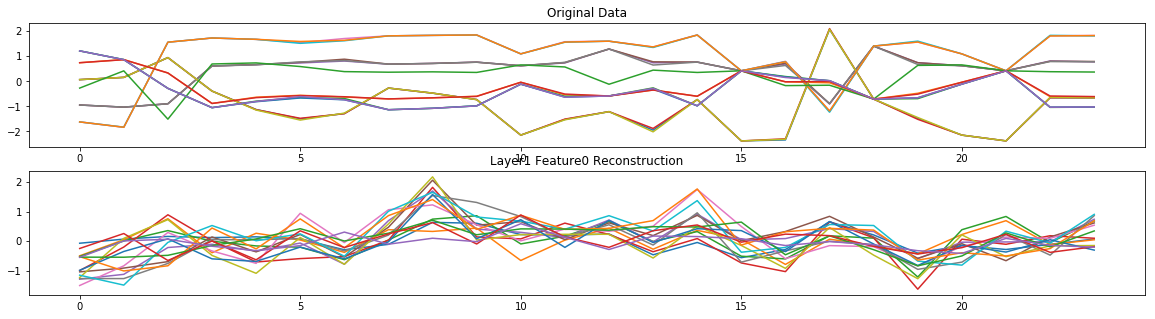

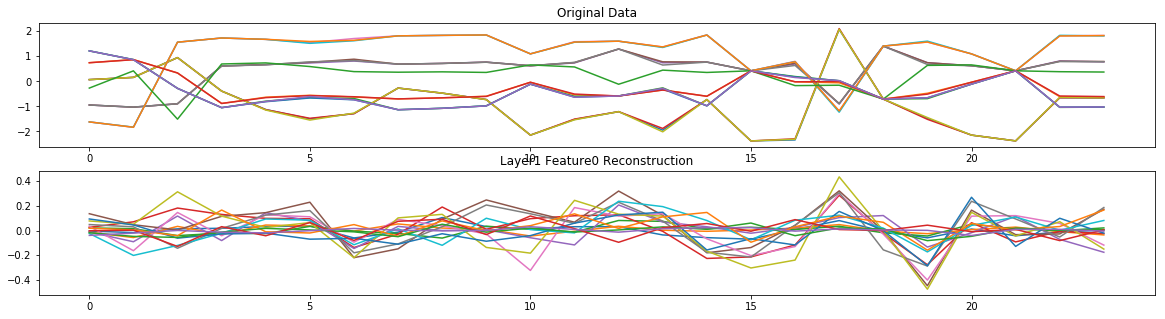

In [13]:
checkAllReconsInOne(input_start, input_end, input_data, layer_nums)

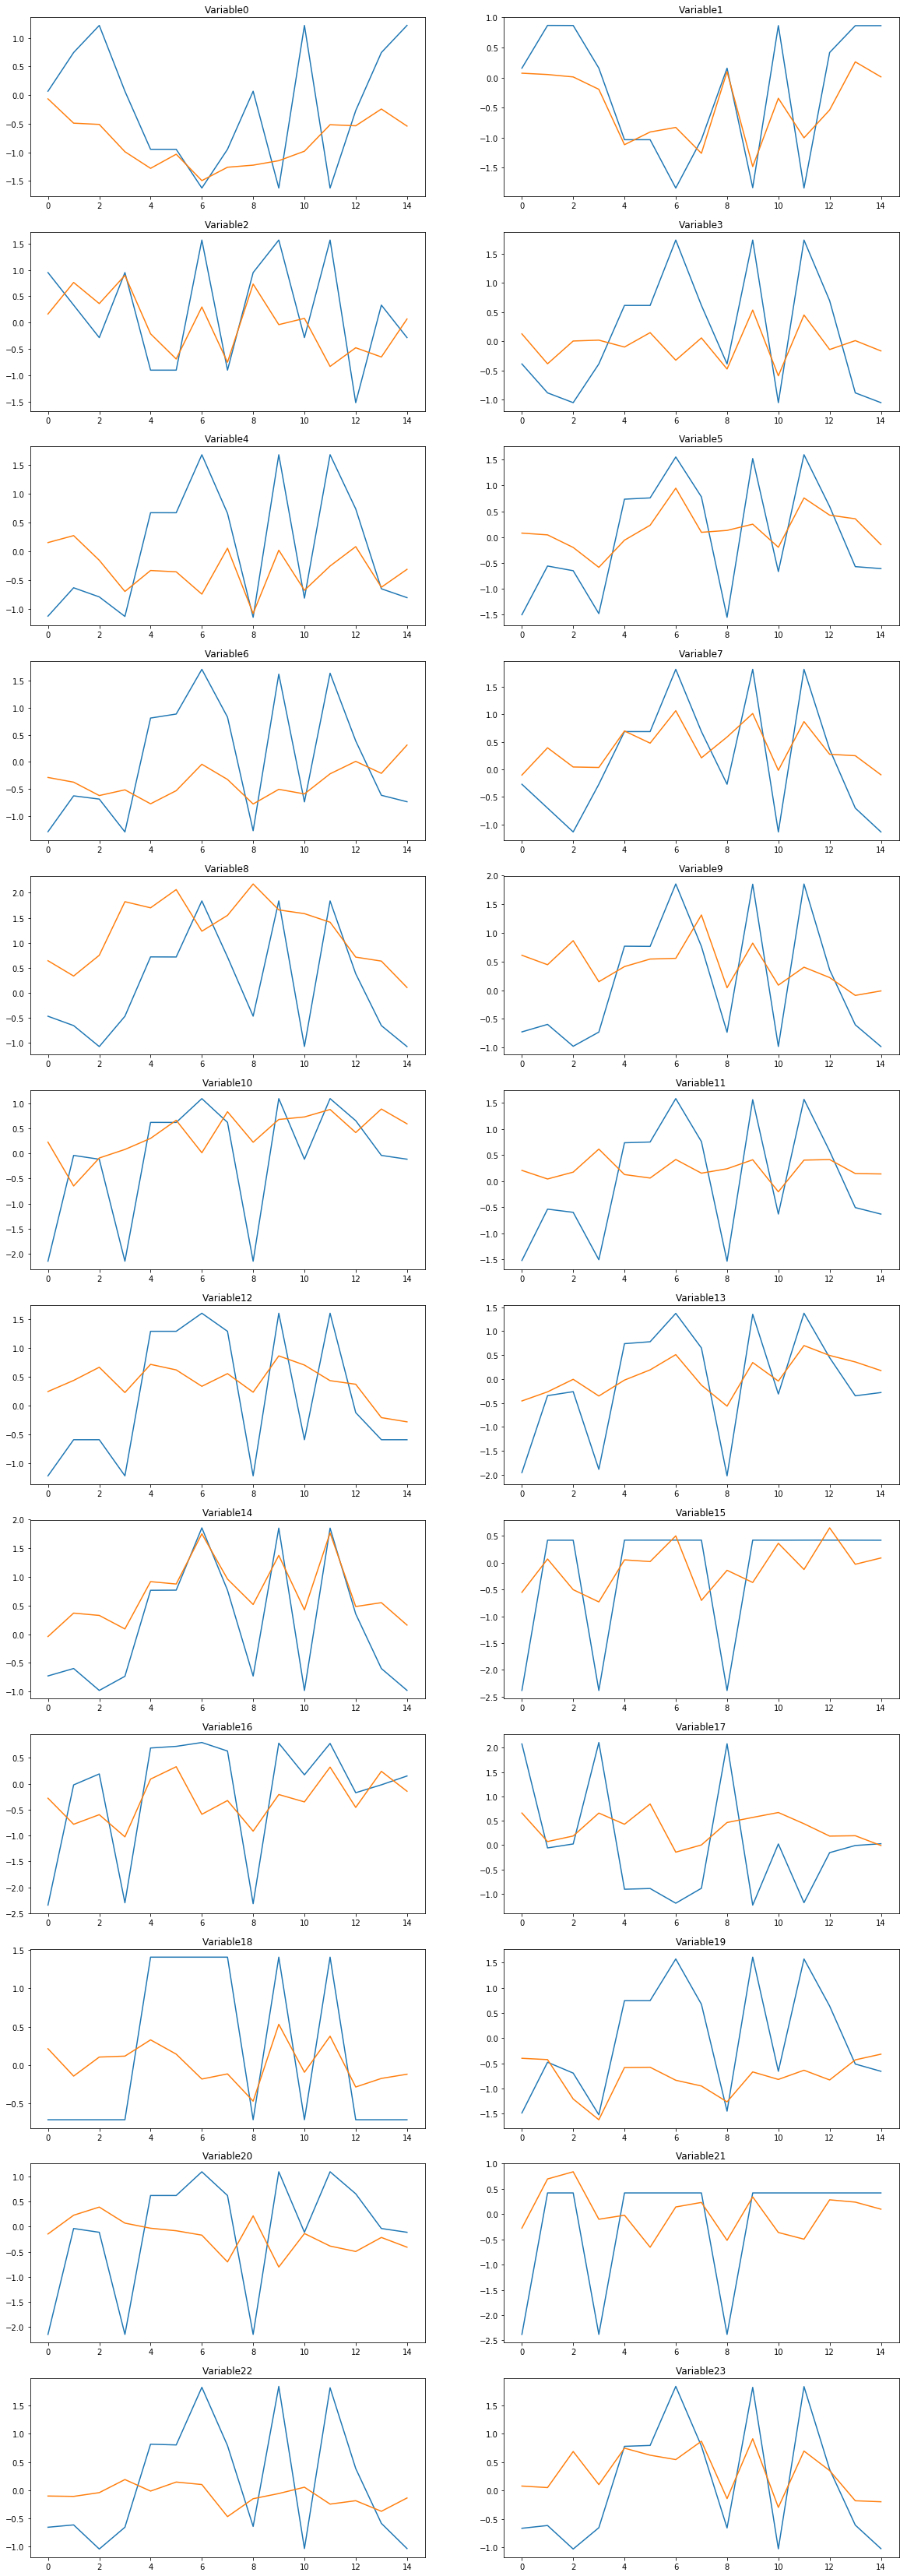

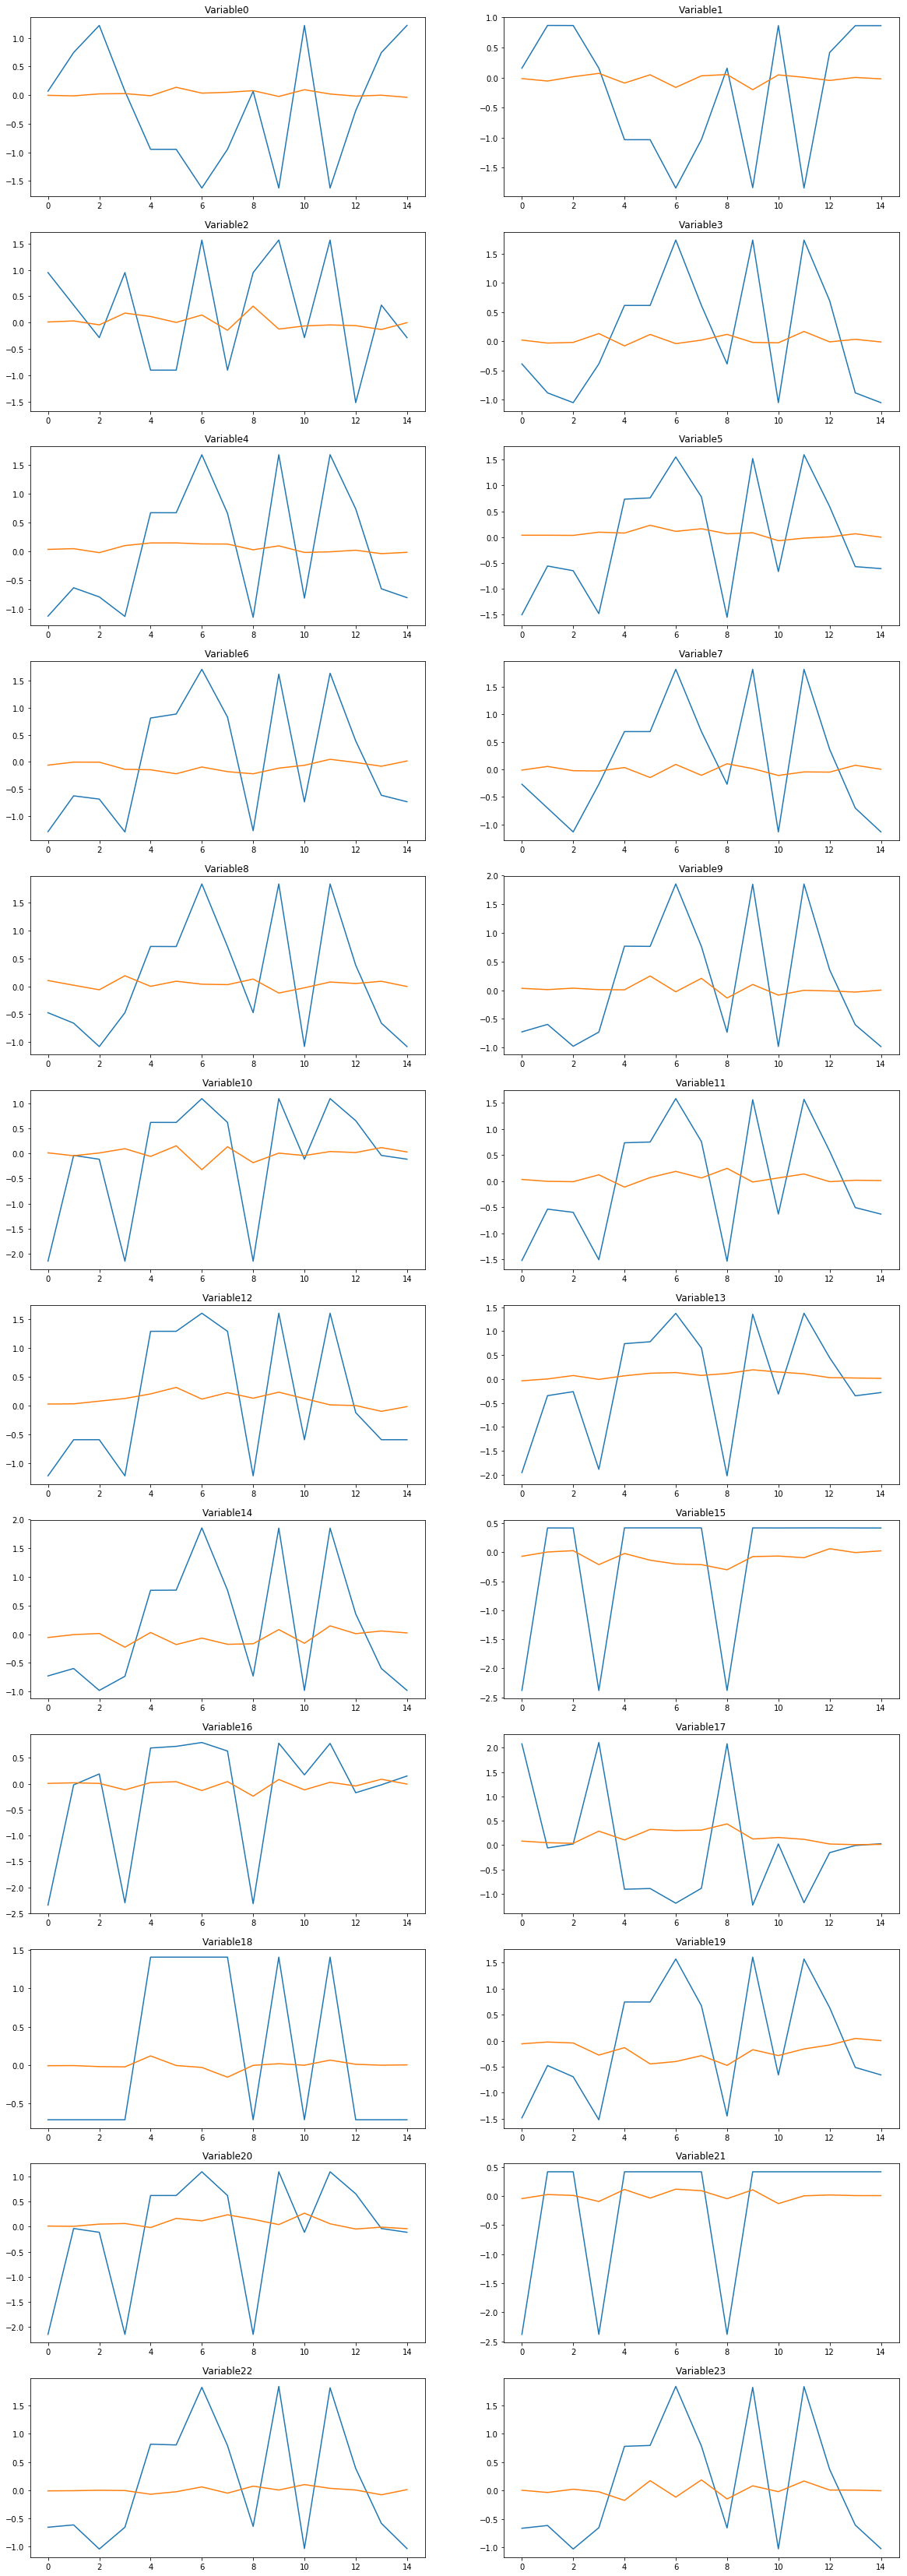

In [9]:
checkAllReconsInSeperate(input_start, input_end, input_data, layer_nums)

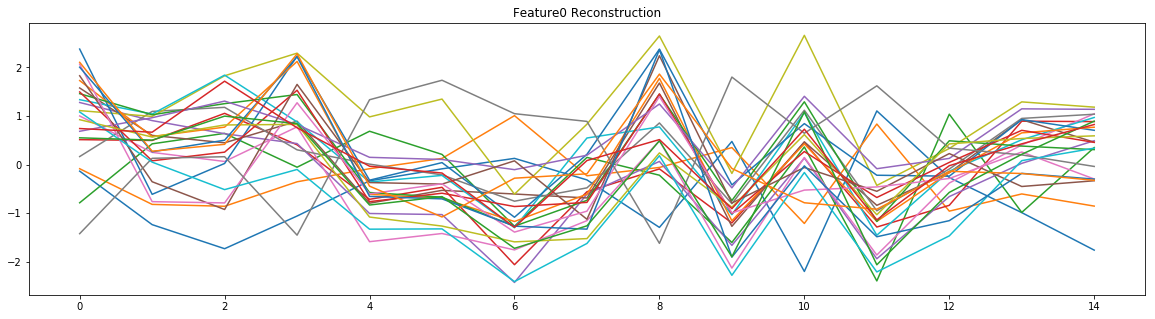

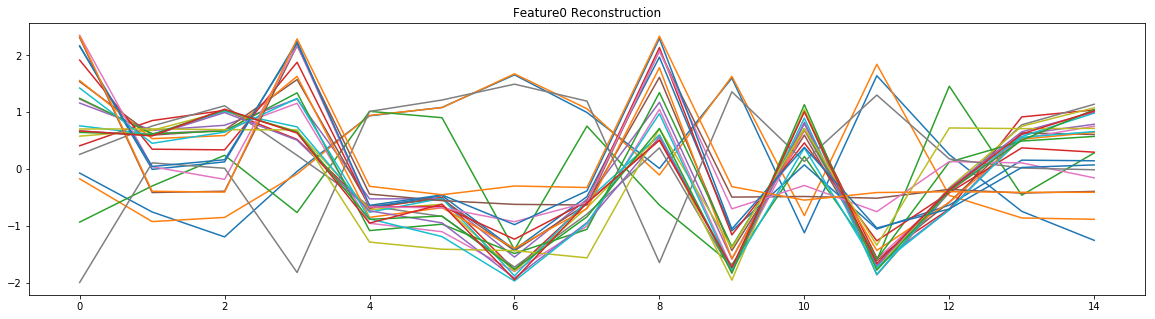

In [10]:
checkAllReconsInOneOfDiff(input_start, input_end, input_data, layer_nums)

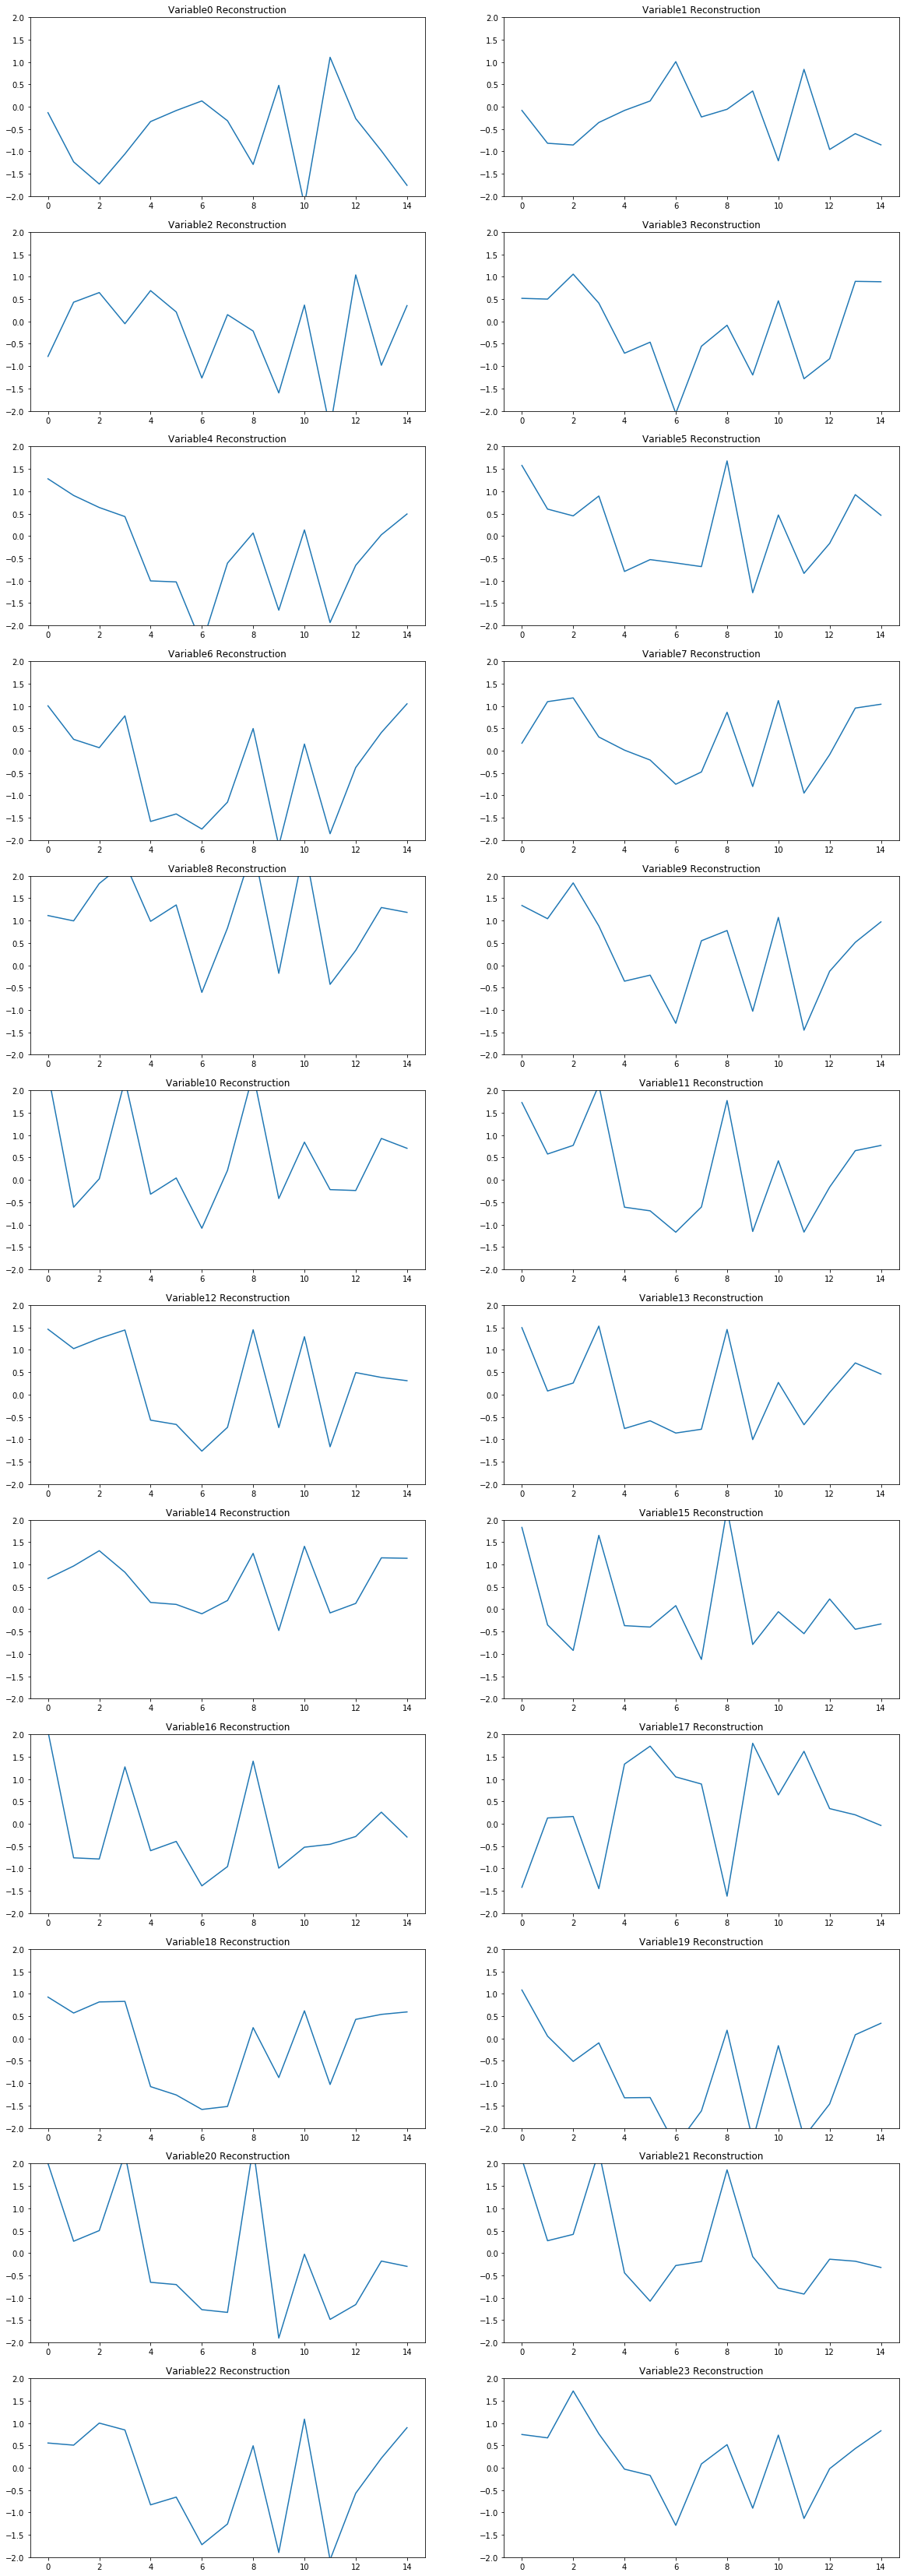

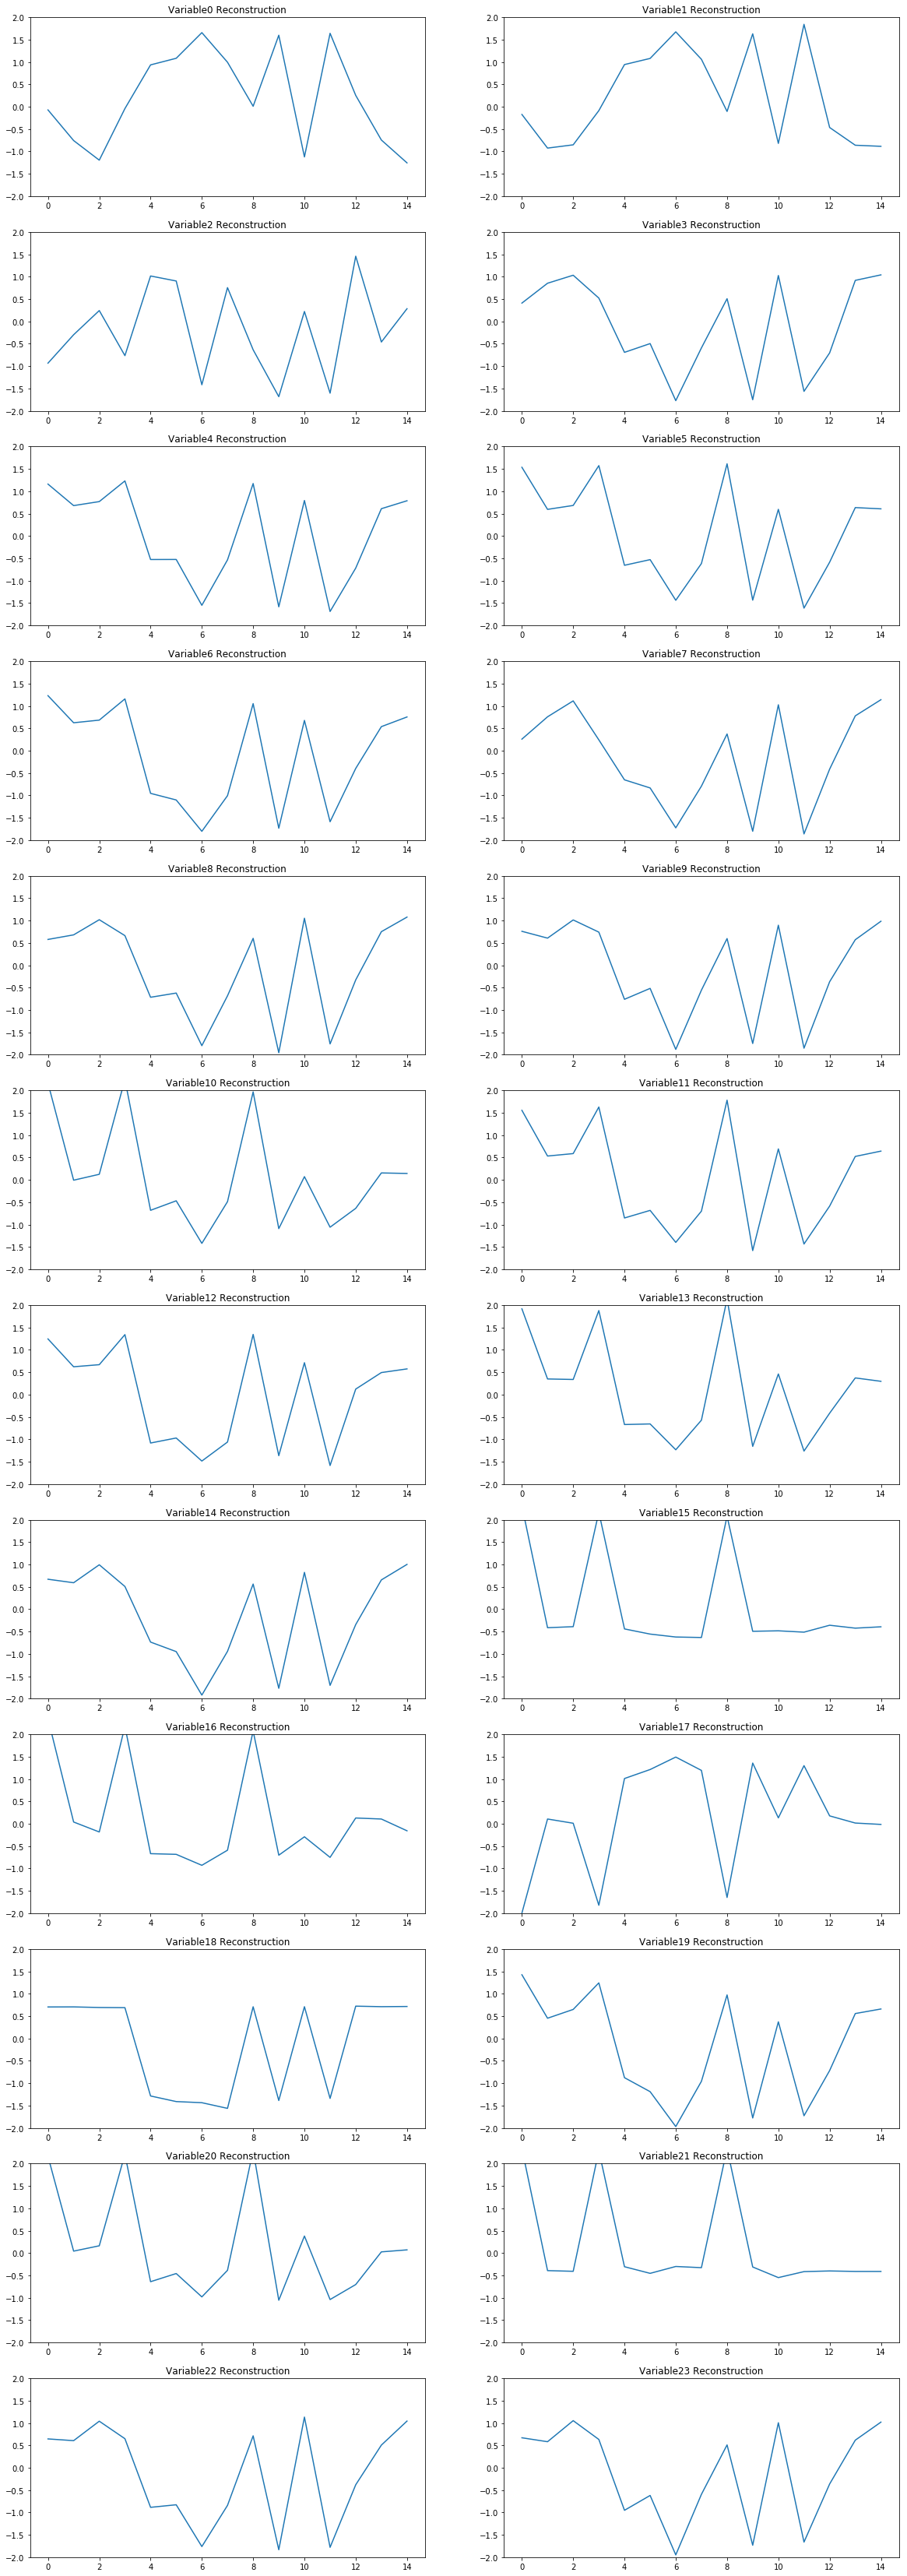

In [12]:
checkAllReconsInSeperateOfDiff(input_start, input_end, input_data, layer_nums)